In [1]:
#code of Interactive Quantum Classifier Inspired by Quantum Open System Theory
#LINK https://ieeexplore.ieee.org/document/9533917

#LINK https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9533917

#this code was written by Fernando Maciano de Paula Neto (fernando@cin.ufpe.br) together with Eduardo Barreto Brito (ebb2@cin.ufpe.br)

In [2]:
import numpy as np
from scipy.linalg import expm as expMatrix
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from matplotlib.collections import EventCollection

In [3]:
def create_sigmaE(vectorX, vectorW):
  """
    Multiplies the input (vectorX) by the weights (vectorW),
    resulting in a diagonal matrix.
    Equivalent of Equation #17 in the Article.
  """
  n = len(vectorX)
  sigmaE = np.zeros((n,n))
  for i in range(n):
    sigmaE[i,i] = vectorX[i]*vectorW[i]

  return sigmaE

In [4]:
def create_sigmaQ(n):
  """
    Sums sigmaX, sigmaY and sigmaZ to get sigmaQ.
    - sigmaX comes from Equation #7 = [0, 1   1, 0]
    - sigmaY comes from Equation #8 = [0, -i  i, 0]
    - sigmaZ comes from Equation #9 = [1, 0   0, -1]
    Equivalent of Equation #16 in the Article.
  """
  sigmaQ = np.zeros((n,n))
  sigmaX = np.array([[0,1], [1,0]])
  sigmaY = np.array([[0,-1j], [1j,0]])
  sigmaZ = np.array([[1,0], [0,-1]])
  sigmaQ = sigmaX + sigmaY + sigmaZ

  return sigmaQ

In [5]:
def create_Uoperator(sigmaQ, sigmaE):
  """
  Makes the exponential matrix of tensor product between sigmaQ and sigmaE and multiplies it by j. 
  Equivalent of Equation #15 in the Article.
  """
  return np.matrix(expMatrix(1j*np.kron(sigmaQ, sigmaE)))

In [6]:
def create_p(psi):
  """
    Creates a matrix out of psi and multiply it against its inverse, 
    resulting in a column vector in the form [[alfa]. [beta]].
    Does the operation |psi><psi| from Equation #18 or #19 in the Article.
  """
  psi = np.matrix(psi)
  return psi * psi.getH()

In [7]:
def create_classifier(vectorX, vectorW):
  """
    Applies the ICQ classifier using only the math behind the Quantum Classifier 
    described in Interactive Quantum Classifier Inspired by Quantum Open System Theory
    article. 
    After doing so, it gets the result of Equation #20 and returns Z as the predicted class and
    the probability of being the class 1.
    Works only for binary classifications, therefore, if the probability of class 0 is needed, it can
    be 1 - probability of being class 1.
  """

  # Eq #16
  sigmaQ = create_sigmaQ(2)

  # Eq #17
  sigmaE = create_sigmaE(vectorX, vectorW)

  # Eq #15
  U_operator = create_Uoperator(sigmaQ, sigmaE)

  # Eq #18 applied on a Quantum state equivalent of Hadamard(|0>) = 1/sqrt(2) * (|0> + |1>) 
  p_cog = create_p([[1/np.sqrt(2)],[1/np.sqrt(2)]])

  # As we must have 1 row per attribute of the input, we need env to be as big as one instance of our input
  N = len(vectorX)

  # Eq #19 applied on a Quantum state equivalent of Hadamard(|000000...>) = 1/sqrt(N) * (|000000...> + ... + |11111111....>) 
  p_env = create_p([[1/np.sqrt(N)] for i in range(N)])

  # First part of Equation #20 in the Article
  quantum_operation = np.array(U_operator * (np.kron(p_cog, p_env)) * U_operator.getH())

  # Second part of Equation #20 in the Article
  p_cog_new = np.trace(quantum_operation.reshape([2,N,2,N]), axis1=1, axis2=3)

  # As the result is a diagonal matrix, the probability of being class 0 will be on position 0,0
  p_cog_new_00_2 = p_cog_new[0,0]

  # ... and the probability of being class 1 will be on position 1,1
  p_cog_new_11_2 = p_cog_new[1,1]
  if (p_cog_new_00_2 >= p_cog_new_11_2):
    z = 0
  else:
    z = 1
  return z, p_cog_new_11_2

In [8]:
VARY_INPUT = 1
VARY_WEIGHT = 2
VARY_BOTH = 3
DIFFERENT_VARIATIONS = [VARY_INPUT, VARY_WEIGHT, VARY_BOTH]

In [9]:
def generate_many_points(n_points, n_dimensional, scale=0.5, varied_part=1):
  list_of_x = []
  list_of_y = []
  list_of_z = []
  
  for i in range(n_points):
    # We need to study what happens when we variate different things
    if varied_part == VARY_INPUT:
      i_n = np.random.uniform(low=-3, high=3, size=(n_dimensional,))
      w_n = scale*np.ones((n_dimensional,))
    elif varied_part == VARY_WEIGHT:
      i_n = scale*np.ones((n_dimensional,))
      w_n = np.random.uniform(low=-3, high=3, size=(n_dimensional,))
    elif varied_part == VARY_BOTH:
      i_n = np.random.uniform(low=-3, high=3, size=(n_dimensional,))
      w_n = np.random.uniform(low=-3, high=3, size=(n_dimensional,))
    
    euclidean_distance = euclidean_distances([i_n], [w_n])
    z,p_cog = create_classifier(i_n, w_n)
    list_of_x.append(euclidean_distance[0][0])
    list_of_y.append(p_cog.real)
    list_of_z.append(z)

  return list_of_x, list_of_y, list_of_z

Variation: 1


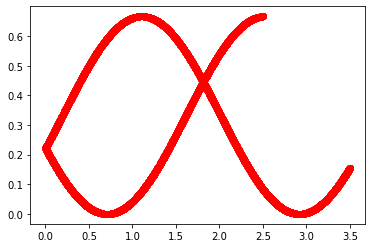

----------------------------------------------
Variation: 2


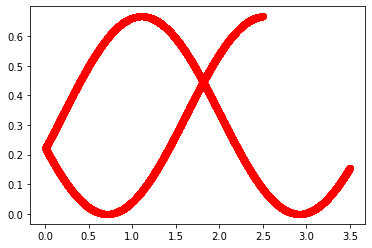

----------------------------------------------
Variation: 3


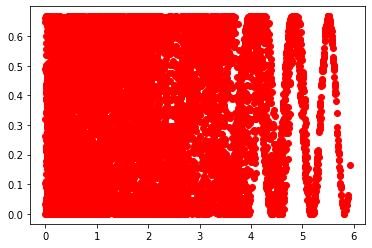

----------------------------------------------


In [10]:
# First let's see only what happens when we change what we're trying to vary
for variation in DIFFERENT_VARIATIONS:
    print("Variation:", variation)
    list_of_x, list_of_y, list_of_z = generate_many_points(10000, 1, varied_part=variation)
    plt.plot(list_of_x, list_of_y, color="red", marker="o",  linestyle="")
    plt.show()
    print("----------------------------------------------")

Variation: 1


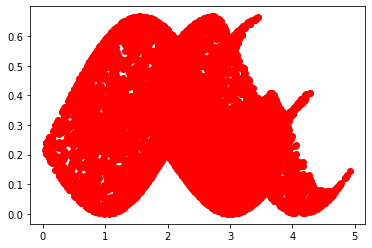

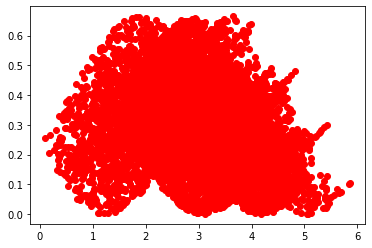

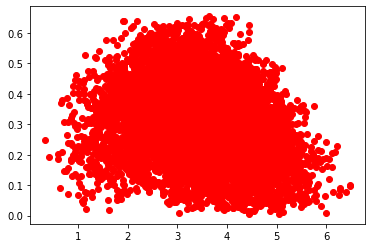

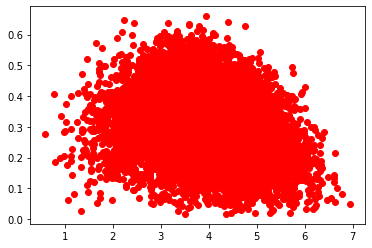

----------------------------------------------
Variation: 2


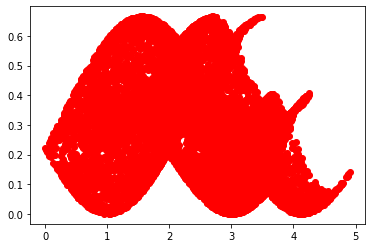

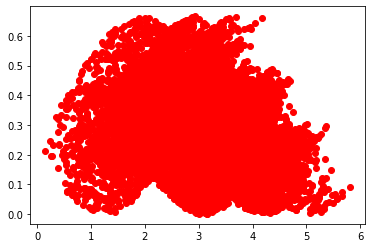

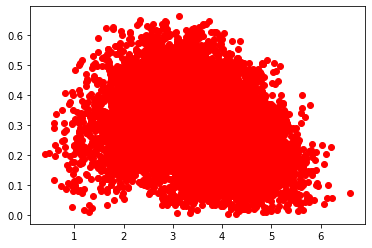

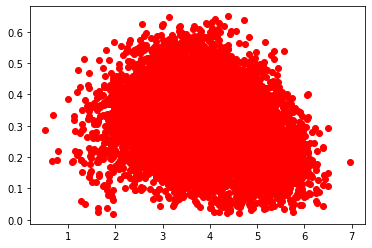

----------------------------------------------
Variation: 3


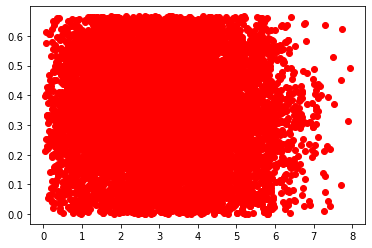

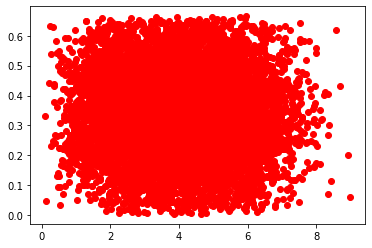

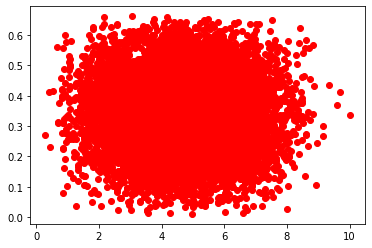

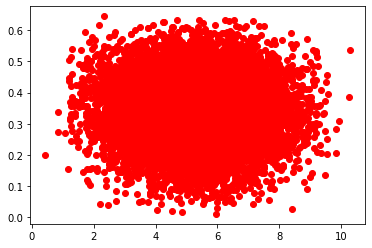

----------------------------------------------


In [11]:
# Then we see what happens with different number of dimensions
for variation in DIFFERENT_VARIATIONS:
    print("Variation:", variation)
    for n in range(2, 6):
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, n, varied_part=variation)
        plt.plot(list_of_x, list_of_y, color="red", marker="o",  linestyle="")
        plt.show()
    print("----------------------------------------------")

Variation: 1


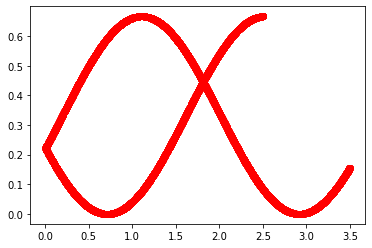

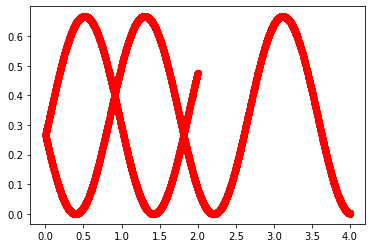

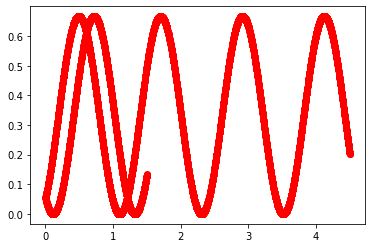

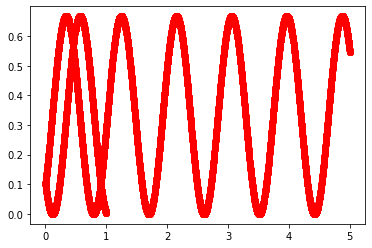

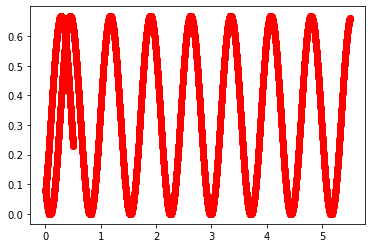

----------------------------------------------
Variation: 2


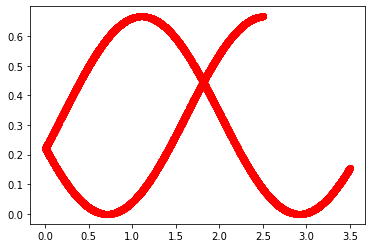

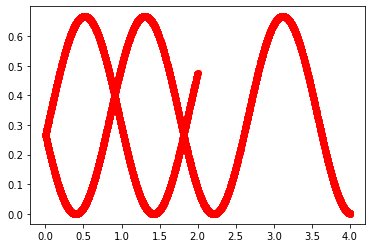

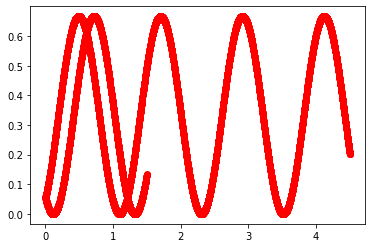

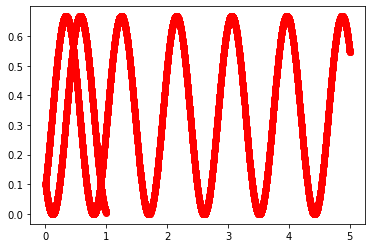

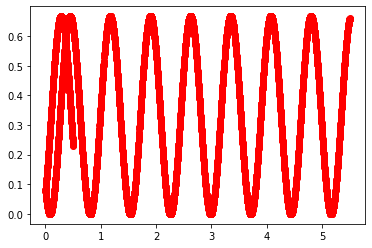

----------------------------------------------


In [12]:
# Last thing we want to know is how the scale affects the points
for variation in [VARY_INPUT, VARY_WEIGHT]:
    print("Variation:", variation)
    for n in np.arange(0.5, 3, 0.5):
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, 1, scale=n, varied_part=variation)
        plt.plot(list_of_x, list_of_y, color="red", marker="o",  linestyle="")
        plt.show()
    print("----------------------------------------------")

In [13]:
def generate_diagram_and_exponent(logisticFun, iterations, last, display_lyapunov=True, n=10000, limInf=2.5, limSup=4, x=1e-5):
        r = np.linspace(limInf, limSup, n)
        lyapunov = np.zeros(n)
        x = x * np.ones(n)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 9),
        sharex=True)
        for i in range(iterations):
                x = logisticFun(r, x)
                # We compute the partial sum of the
                # Lyapunov exponent.
                lyapunov += np.log(abs(r - 2 * r * x))
                # We display the bifurcation diagram.
                if i >= (iterations - last):
                        ax1.plot(r, x, ',k', alpha=.25)
        
        ax1.set_xlim(limInf, limSup)
        ax1.set_title("Bifurcation diagram")

        if (display_lyapunov):
                # We display the Lyapunov exponent.
                # Horizontal line.
                ax2.axhline(0, color='k', lw=.5, alpha=.5)
                # Negative Lyapunov exponent.
                ax2.plot(r[lyapunov < 0],
                lyapunov[lyapunov < 0] / iterations,
                '.k', alpha=.5, ms=.5)
                # Positive Lyapunov exponent.
                ax2.plot(r[lyapunov >= 0],
                lyapunov[lyapunov >= 0] / iterations,
                '.r', alpha=.5, ms=.5)
                ax2.set_xlim(limInf, limSup)
                ax2.set_ylim(-2, 2)
                ax2.set_title("Lyapunov exponent")
        print(plt.tight_layout())

None


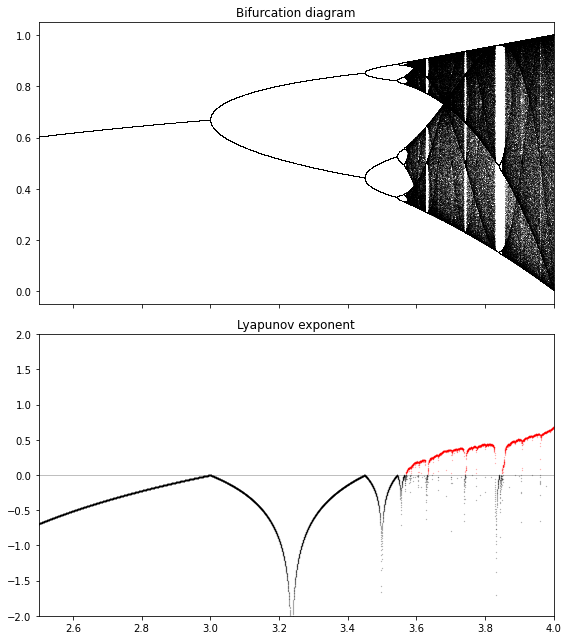

In [14]:
def logistic(r, x):
    return r * x * (1 - x)
generate_diagram_and_exponent(logistic, 100000, 100)

KeyboardInterrupt: 

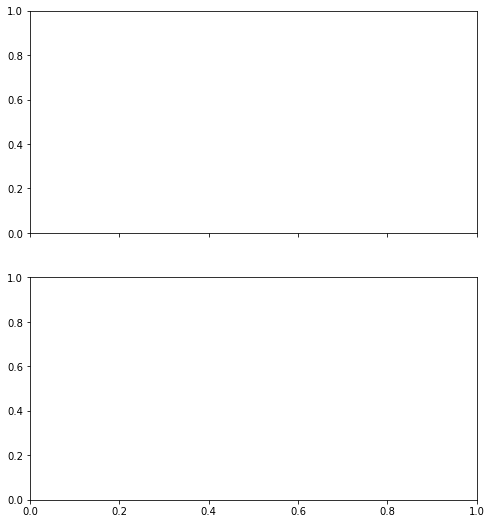

In [15]:
def logistic(r, x):
    result = []
    for r_n, x_n in zip(r,x):
      z,p_cog = create_classifier(np.array([x_n]), np.array([r_n]))
      result.append(p_cog.real)
    return result
generate_diagram_and_exponent(logistic, 1000, 100)

In [ ]:
for iterations in range(1000, 10000, 1000):
  print("Iterations:", iterations)
  generate_diagram_and_exponent(logistic, iterations, 100)
  print("-------------------------------------------------------------")